In [10]:
def make_sig_mtrx(fly,parallel = True):
    def get_line_database():
        #print line_name
        import cPickle
        f = open('/media/analysis-code/flight-muscles/experimental/mn_expression_matrix_plot/line_database.cpkl','rb')
        line_database = cPickle.load(f)
        f.close()
        return line_database

    def parse_GMR_genotype(genotype):
        """get the GMR and UAS keys in a given genotype"""
        print genotype
        gcamp_idx =  genotype.find('GCaMP6f')
        GFP_idx = genotype.find('GFP')
        gmr_idx = genotype.find('GMR')
        gmr_str = genotype[gmr_idx+3:gmr_idx+8]
        if gcamp_idx > 0:
            return {'uas':'GCaMP6f','gal4':gmr_str}
        elif GFP_idx > 0:
            return {'uas':'eGFP','gal4':gmr_str}

    def get_signal_dict(fly):
        """merge the signals from the nnls fits and the fly_record file into a single dictionary"""
        import h5py
        import cPickle
        import numpy as np
        fly_path = fly.fly_path
        muscle_data_file = fly_path+ 'nnls_fits_bk_sub_F.cpkl'
        #muscle_data_file = fly_path+'nnls_fits_no_bk_dF_F.cpkl'
        fly_record_file = fly_path+'fly_record.hdf5'
        signal_dict = dict()
        fi = open(muscle_data_file,'rb')
        muscle_data = cPickle.load(fi)
        fi.close()
        for mu,sig in zip(muscle_data['muscles'],muscle_data['fits']):
            signal_dict[mu] = sig
        hf = h5py.File(fly_record_file,'r')
        exp_record = hf['experiments'].values()[0]
        for key in exp_record['tiff_data']['axon_framebase'].keys():
            signal_dict[key] = np.array(exp_record['tiff_data']['axon_framebase'][key])
        hf.close()
        return signal_dict
    
    #try:
    import group_data as gd
    from scipy.interpolate import griddata
    import numpy as np
    import flylib

    line_profile = get_line_database()[parse_GMR_genotype(fly.get_genotype())['gal4']]
    muscles_in_line = [key for key,item in line_profile.items() if (item  > 0)]
    muscles_in_line = [m for m in muscles_in_line if not(m == 'ps')]
    #print muscles_in_line

    sigs = get_signal_dict(fly)#fly_dict['sigs']
    fly_path = fly.fly_path#fly_dict['fly_path']
    trials = flylib.idx_by_thresh(sigs['StimCond'],0.0)
    exp_name = fly.list_expmnts()[0]
    signal_mtrxs = dict()

    xi = np.linspace(0,23,1150)

    ##########
    ##### Motion stim
    ##########
    for key in sigs:
        signal_mtrxs[key] = list()

    signal_mtrxs['trial_cond'] = list()
    signal_mtrxs['fly_num'] = list()
    signal_mtrxs['exp_names'] = list()
    signal_mtrxs['trial_time'] = list()

    for trial in trials:
        try:
            cond = gd.decode_map[exp_name](sigs['StimCond'][trial])
            t0 = sigs['times'][trial][0]
            tn = sigs['times'][trial][-1]

            signal_mtrxs['trial_time'].append(np.array([t0,tn]))

            times = sigs['times'][trial] - sigs['times'][trial[0]]

            #signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            for skey in sigs.keys():#['wb_period','wb_frequency','strobe_time','Ph0','Ph1','Ph2','Ph3','StimCond']:
                #print trial
                #print shape(trial)
                #print shape(times)
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError'
    ##########
    ##### Stripe fixation
    ##########
    stfix = flylib.idx_by_thresh(sigs['StimCond']*-1,0.5)[0]
    t0 = sigs['times'][stfix][0]
    tn = sigs['times'][stfix][-1]
    while ((t0+23.5) < tn):
        trial = np.squeeze(np.where((sigs['times'] > t0) & (sigs['times'] < (t0+23))))
        try:
            cond = 'stripe_fix'
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            #signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            signal_mtrxs['trial_time'].append(np.array([t0,t0+23]))
            for skey in sigs.keys():
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
            t0 += 23
        except ValueError:
            print 'ValueError'
    ##########
    ##### Flight starts
    ##########
    fsig = np.array(sigs['wb_frequency'])
    #fsig = hstack((fsig,[0,0]))
    print fsig
    epoch_times = [(sigs['times'][ep[0]]-5,
                    sigs['times'][ep[0]]+18) for ep in flylib.idx_by_thresh(fsig,50) if np.shape(ep)[0]>500]

    trials = [np.squeeze(np.where((sigs['times'] > ep[0]) & (sigs['times'] < ep[1]))) for ep in epoch_times]
    ### need to find a better way to extract the #frames
    #print sigs
    trials = [ep for ep in trials if (ep[-1] < len(sigs[muscles_in_line[0]]))]
    xi = np.linspace(0,23,1150)
    for trial in trials:
        try:
            cond = 'flight_starts'
            t0 = sigs['times'][trial][0]
            tn = sigs['times'][trial][-1]

            times = sigs['times'][trial] - sigs['times'][trial[0]]
            signal_mtrxs['trial_time'].append(np.array([t0,tn]))

            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            for skey in sigs.keys():
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError'

    ##########
    ##### Flight stops
    ##########
    
    epoch_times = [(sigs['times'][ep[-1]]-5,
                    sigs['times'][ep[-1]]+18) for ep in flylib.idx_by_thresh(fsig,50) if np.shape(ep)[0]>500]

    trials = [np.squeeze(np.where((sigs['times'] > ep[0]) & (sigs['times'] < ep[1]))) for ep in epoch_times]
    trials = [ep for ep in trials if (ep[-1] < len(sigs[muscles_in_line[0]]))]
    xi = np.linspace(0,23,1150)
    for trial in trials:
        try:
            cond = 'flight_stops'
            t0 = sigs['times'][trial][0]
            tn = sigs['times'][trial][-1]
            #print trial
            times = sigs['times'][trial] - sigs['times'][trial[0]]
            signal_mtrxs['trial_time'].append(np.array([t0,tn]))

            signal_mtrxs['trial_cond'].append(cond)
            signal_mtrxs['fly_num'].append(fly.fly_num)
            signal_mtrxs['exp_names'].append(exp_name)
            for skey in sigs.keys():
                resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                signal_mtrxs[skey].append(resamp)
        except ValueError:
            print 'ValueError' 

    for key in signal_mtrxs:
        signal_mtrxs[key] = np.array(signal_mtrxs[key])

    if parallel:
        import cPickle
        #f = open(fly.fly_path + 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl','wb')
        f = open(fly.fly_path + 'nnls_fits_bk_sub_F_sig_mtrx.cpkl','wb')
        cPickle.dump(signal_mtrxs,f)
        f.close()
    else:
        return signal_mtrxs
    #except Exception, err: # catch *all* exceptions
    #    return err

In [11]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [12]:
def sanity_check(fly):
    """make sure the list of decoded trials matches 
    those saved in the trial_data.cpkl file should return 0"""
    import flylib as flb
    import group_data as gd
    import re
    reload(gd)
    fly.open_fly_record()
    expmnt = fly.get_expmnt(fly.list_expmnts()[0])
    try:
        trial_data = fly.get_pkl_data('trial_data.cpkl')
        sconds = np.array(expmnt['tiff_data']['axon_framebase']['StimCond'])
        epochs = flb.idx_by_thresh(sconds,0.0)
        pat_names = [gd.decode_cond_pitch_roll(sconds[ep]) for ep in epochs]
        parse = lambda pname:re.sub(r'Pattern_','',re.sub(r'_v._rep..mat','',pname))
        #print [parse(td['pattern_name']) == pname for td,pname in zip(trial_data,pat_names)]
        #print trial_data[0]
        #return len(trial_data) - sum([parse(td['pattern_name']) == pname for td,pname in zip(trial_data,pat_names)])
        return len(trial_data) - sum([parse(td[[0]]) == pname for td,pname in zip(trial_data,pat_names)])

    except IOError:
        return 'no trial data'

In [13]:
#StimCondfly.get_pkl_data('trial_data.cpkl')[0][0]

In [14]:
import group_data as gd
reload(gd)
#file_name = 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl',
#flylist = [gd.GMR22H05_pr_swarm.flies+gd.GMR22H05_prc_swarm.flies+ gd.GMR22H05_swarm.flies][0]
#flylist = gd.get_update_list(swarms = [gd.GMR22H05_pr_swarm,gd.GMR22H05_prc_swarm, gd.GMR22H05_swarm],
#                             file_name = 'nnls_fits_bk_sub_F_sig_mtrx.cpkl',
#                             replace = True)
flylist = gd.swarms['GMR39E01_yr'].flies

In [15]:
#flylist[-4:]

In [16]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [17]:
#parallize accross flies
from IPython.parallel import Client
clients = Client() 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3]


In [18]:
v.map(make_sig_mtrx,flylist)

[None, None, None, None, None, None, None, None, None, None, None, None]

In [10]:
expmnt = fl.get_expmnt(fl.list_expmnts()[0])

NameError: name 'fl' is not defined

In [22]:
fsig = np.array((expmnt['tiff_data']['axon_framebase']['wb_frequency']))

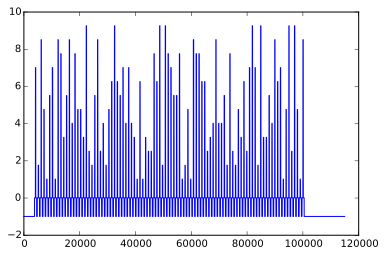

In [17]:
plb.plot(fsig)

In [23]:
import flylib as flb
reload(flb)
print flb.idx_by_thresh(fsig,0)

[]
[array([     1,      2,      3, ..., 114998, 114999, 115000])]


In [21]:
os.listdir(flylist[-4].fly_path)

['epoch_data.cpkl',
 'genotype.txt',
 'basis_fits.cpkl',
 'nnls_fits_bk_sub_F.cpkl',
 'note.txt',
 'fly_record.hdf5']

In [16]:
[make_sig_mtrx(fl) for fl in flylist[-4:]]

+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR39E01-GAL4}attP2/+
[  4.28522822e-02   4.28522822e-02   4.28522822e-02 ...,   1.72846558e+02
   1.74376411e+02   1.75697821e+02]
+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR39E01-GAL4}attP2/+
[ 0.03154924  0.03154924  0.03154924 ...,         inf         inf
         inf]
+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR39E01-GAL4}attP2/+
[  1.92347493e-02   1.92347493e-02   1.92347493e-02 ...,   1.77563614e+02
   1.73178368e+02   1.73885020e+02]
+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR39E01-GAL4}attP2/+
[  4.33314614e-02   4.33314614e-02   4.33314614e-02 ...,   1.73760217e+02
   1.71770614e+02   1.77130944e+02]


[None, None, None, None]

In [68]:
ls '/media/analysis-code/flight-muscles/experimental/mn_expression_matrix_plot/'

group_summary.csv           mn_matrix.xlsx
line_database.cpkl          mu_image_assesment.csv
line_profile.pdf            mu_matrix.csv
line_profile_small.pdf      mu_matrix.xlsx
mn_expression_matrix.ipynb  wing motorneuron screen (1).xlsx
mn_matrix.csv


In [81]:
import os
os.listdir(fly.fly_path)

['nnls_fits_bk_sub_F_sig_mtrx.cpkl',
 'epoch_data.cpkl',
 'experiment_script.cpkl',
 'genotype.txt',
 'basis_fits.cpkl',
 'nnls_fits_bk_sub_F.cpkl',
 'trial_data.cpkl',
 'note.txt',
 'fly_record.hdf5']

In [82]:
fly.get_pkl_data('nnls_fits_bk_sub_F_sig_mtrx.cpkl')

{u'CamSync': array([[ 5.10859919,  5.10681381,  5.1079542 , ...,         nan,
                 nan,         nan],
        [ 5.10518932,  5.10759361,  5.10592472, ...,         nan,
                 nan,         nan],
        [ 5.10661602,  5.10810423,  5.10596049, ...,         nan,
                 nan,         nan],
        ..., 
        [ 5.1061945 ,  5.10803793,  5.10760255, ...,  5.10718692,
                 nan,         nan],
        [ 5.10692883,  5.1064827 ,  5.10508957, ...,  5.10559857,
                 nan,         nan],
        [ 5.10673714,  5.10849806,  5.10784465, ...,  5.10734949,
                 nan,         nan]]),
 u'CamTrig': array([[ 0.29915729,  0.29151091,  0.29547023, ...,         nan,
                 nan,         nan],
        [ 0.2961078 ,  0.30211014,  0.29308937, ...,         nan,
                 nan,         nan],
        [ 0.29051045,  0.29322712,  0.30076722, ...,         nan,
                 nan,         nan],
        ..., 
        [ 0.29383361,  0.297

In [83]:
pkdata = Out[82]